<a href="https://colab.research.google.com/github/siskakrislim/deep-learning/blob/master/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%shell

# wget 'https://www.dropbox.com/sh/1lbees2cn34ysse/AAB9VKqNFMJSmzdtZgaU1s9ua?dl=0&preview=ILSVRC2012_bbox_val_v3.tgz'
# wget 'https://www.dropbox.com/sh/1lbees2cn34ysse/AAB9VKqNFMJSmzdtZgaU1s9ua?dl=0&preview=imagenet2500.tar'
# wget 'https://drive.google.com/open?id=1BxP4oBryJ7Yb0-PbmW2sn97PD_J7RNiL'
unzip imagespart.zip

Archive:  imagespart.zip
  inflating: imagespart/ILSVRC2012_val_00000001.JPEG  
  inflating: imagespart/ILSVRC2012_val_00000002.JPEG  
  inflating: imagespart/ILSVRC2012_val_00000003.JPEG  
  inflating: imagespart/ILSVRC2012_val_00000004.JPEG  
  inflating: imagespart/ILSVRC2012_val_00000005.JPEG  
  inflating: imagespart/ILSVRC2012_val_00000006.JPEG  
  inflating: imagespart/ILSVRC2012_val_00000007.JPEG  
  inflating: imagespart/ILSVRC2012_val_00000008.JPEG  
  inflating: imagespart/ILSVRC2012_val_00000009.JPEG  
  inflating: imagespart/ILSVRC2012_val_00000010.JPEG  
  inflating: imagespart/ILSVRC2012_val_00000011.JPEG  
  inflating: imagespart/ILSVRC2012_val_00000012.JPEG  
  inflating: imagespart/ILSVRC2012_val_00000013.JPEG  
  inflating: imagespart/ILSVRC2012_val_00000014.JPEG  
  inflating: imagespart/ILSVRC2012_val_00000015.JPEG  
  inflating: imagespart/ILSVRC2012_val_00000016.JPEG  
  inflating: imagespart/ILSVRC2012_val_00000017.JPEG  
  inflating: imagespart/ILSVRC2012_val_0

False


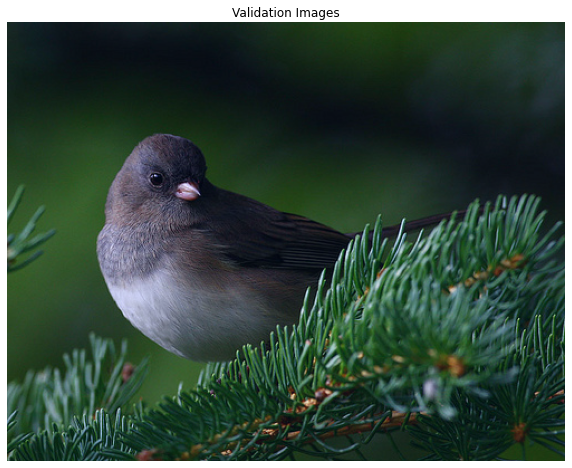

In [0]:
import torchvision.models as models
import os 
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import time
from PIL import Image
from torchvision.transforms import transforms
import torch
import numpy as np
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from __future__ import print_function, absolute_import
'''
#1: Get 2500 ImageNet validation set
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
val_path = 'imagespart'
normalize = transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
#without tencrop
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.RandomResizedCrop(256),
                                transforms.RandomRotation(60),
                                transforms.ToTensor(),
                                normalize])
#unaugmented
transform1 = transforms.Compose([transforms.ToTensor(),
                                normalize])
#with tencrop
transform2 = transforms.Compose([#transforms.ToPILImage(),
                                transforms.RandomResizedCrop(256),
                                transforms.RandomRotation(60),
                                transforms.Resize(256),
                                transforms.TenCrop(224),
                                transforms.ToTensor(),
                                normalize,
                                ])
val_set = datasets.ImageFolder(root=val_path,transform=transform1)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True,num_workers=4,pin_memory=True)
# val_loader = torch.utils.data.DataLoader(val_set,batch_size=32,shuffle=True,num_workers=4,pin_memory=True)

batch = next(iter(val_loader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Validation Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:2500],padding=2,normalize=True).cpu(),(1,2,0)))
#freeze, dataset, dataloader, transform (crop,flip,rotate), normalize, tensor, validation, path, img list, predict, compare against label for accuracy - top 1 & top 5

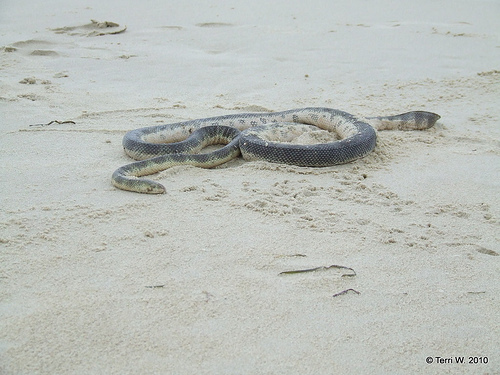

In [0]:
Image.open('/content/imagespart/val/ILSVRC2012_val_00000001.JPEG')

In [0]:
'''
#2: Get resnet50 pretrained model
'''
#model = models.resnet50()
num_classes = 1000
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,num_classes)
for param in model.parameters():
  param.requires_grad=False
model = model.to(device)

for name,child in model.named_children():
  print(name)
  print(child)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(),lr=0.01,momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7,gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



conv1
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu
ReLU(inplace=True)
maxpool
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-0

In [0]:
# 3: perform validation using the resnet50 model in test time augmentation
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    with torch.no_grad():
      maxk = max(topk)
      batch_size = target.size(0)

      _, pred = output.topk(maxk, 1, True, True)
      pred = pred.t()
      correct = pred.eq(target.view(1, -1).expand_as(pred))

      res = []
      for k in topk:
          correct_k = correct[:k].view(-1).float().sum(0,keepdim=True)
          res.append(correct_k.mul_(100.0 / batch_size))
      return res

def validate(val_loader, model, criterion):
    model.eval()
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    # top1 = Accuracy(topK=1)
    # top5 = Accuracy(topK=5)
    end = time.time()
    with torch.no_grad():
      for i, (image, target) in enumerate(val_loader):
          # target = target.cuda()
          # input = input.cuda()

          # compute output
          output = model(image)
          # output = output.cuda()
          loss = criterion(output, target)

          # measure accuracy and record loss
          acc1, acc5 = accuracy(output, target, topk=(1, 5))
          losses.update(loss.item(), image.size(0))
          top1.update(acc1[0], image.size(0))
          top5.update(acc5[0], image.size(0))
          # print("acc1: ",top1)
          # print("acc5: ",top5)

          # measure elapsed time
          batch_time.update(time.time() - end)
          end = time.time()

          if i % 10 == 0:
              print('Test: [{0}/{1}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                    'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                    'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                    i, len(val_loader), batch_time=batch_time, loss=losses,
                    top1=top1, top5=top5))
      print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
            .format(top1=top1, top5=top5))

      return top1.avg
    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# 4: get the top-1 and top-5 accuracy
num_epoch=5
best_acc1 = 0
best_model_wts = copy.deepcopy(model.state_dict())
for epoch in range(num_epoch):
        print('Epoch: {}/{}'.format(epoch+1,num_epoch))
        # evaluate on validation set
        acc1 = validate(val_loader, model, criterion)
        # get the best prec1 and model
        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1)
        if(is_best):
          best_model_wts = copy.deepcopy(model.state_dict())
        model.load_state_dict(best_model_wts)

Epoch: 1/5
Test: [0/2500]	Time 1.320 (1.320)	Loss 7.2143 (7.2143)	Acc@1 0.000 (0.000)	Acc@5 0.000 (0.000)
Test: [10/2500]	Time 0.783 (1.016)	Loss 7.0594 (7.2754)	Acc@1 0.000 (0.000)	Acc@5 0.000 (0.000)
Test: [20/2500]	Time 1.176 (1.187)	Loss 7.4724 (7.2432)	Acc@1 0.000 (0.000)	Acc@5 0.000 (0.000)
Test: [30/2500]	Time 1.005 (1.283)	Loss 7.6292 (7.2250)	Acc@1 0.000 (0.000)	Acc@5 0.000 (0.000)
Test: [40/2500]	Time 0.775 (1.395)	Loss 7.4069 (7.2086)	Acc@1 0.000 (0.000)	Acc@5 0.000 (0.000)
Test: [50/2500]	Time 0.764 (1.294)	Loss 7.1534 (7.2155)	Acc@1 0.000 (0.000)	Acc@5 0.000 (0.000)
Test: [60/2500]	Time 1.011 (1.214)	Loss 7.0877 (7.1983)	Acc@1 0.000 (0.000)	Acc@5 0.000 (0.000)
Test: [70/2500]	Time 0.764 (1.175)	Loss 7.2879 (7.2049)	Acc@1 0.000 (0.000)	Acc@5 0.000 (0.000)
Test: [80/2500]	Time 0.746 (1.140)	Loss 7.2859 (7.2072)	Acc@1 0.000 (0.000)	Acc@5 0.000 (0.000)
Test: [90/2500]	Time 0.734 (1.095)	Loss 6.9291 (7.2060)	Acc@1 0.000 (0.000)	Acc@5 0.000 (0.000)
Test: [100/2500]	Time 0.729 (1

RuntimeError: ignored